In [2]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree

def selection_events(extras = ['']):
    r = ['subrun', 'event']
    if extras != ['']:
        r = r + extras
    return r
def get_event(subrun=0, event=1):
    return (pl.col('subrun')==subrun) & (pl.col('event') == event)

In [3]:
anatree = Anatree("/home/henrique/Documents/Atmos_Pandora/data/test-production/merged_ana_tree_hd.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree
anatree.read_parquet('../../../../../data/test-production/parquet',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)

Reading nu files... 10/10
Reading geant files... 10/10
Reading reco_tracks files... 10/10
Reading reco_showers files... 10/10
Reading pfp files... 10/10


In [4]:
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
showers = anatree.reco_showers
merged:pl.DataFrame
merged = 0
for i,n in enumerate(nu):
    df = anatree.get_full_reco_tracks(tracks[i], geant[i], nu[i])
    df = df.collect()
    if i == 0:
        merged = df
    else:
        merged = pl.concat([merged,df])

In [5]:
geant_nu:pl.DataFrame
geant_nu = 0
for i,n in enumerate(nu):
    dfg = geant[i]#.head(1000000)
    dfnu = n.filter((pl.col('ccnc_truth')==0) & (pl.col('nuPDG_truth').abs()==14))
    dfg = dfg.filter((pl.col('Mother_geant')==0) & (pl.col('pdg_geant').abs() == 13))
    gcc = (
        dfg.join(dfnu, left_on=['subrun','event'], right_on=['subrun', 'event'], how='inner')
    ).collect()
    if i == 0:
      geant_nu = gcc  
    else:
        geant_nu = pl.concat([geant_nu,gcc])
        # if i == 1:
        #    break

In [6]:
df:pl.DataFrame
df = merged

In [7]:
df = df.with_columns(
    track_angle_diff = ((pl.col('trkstartdcosx_pandoraTrack')*pl.col('Px_geant') +
                         pl.col('trkstartdcosy_pandoraTrack')*pl.col('Py_geant') +
                         pl.col('trkstartdcosz_pandoraTrack')*pl.col('Pz_geant'))/pl.col('P_geant')).arccos()
)


In [8]:

def create_intervals():
    global Ebins
    intervals = []
    for i, e in enumerate(Ebins[:-1]):
        intervals.append(f'[{e} - {Ebins[i+1]}) GeV')
    return intervals
def plot_by_energy(bins, df:pl.DataFrame, variables, labels, fig=None, columns = 3, show_entries=False, **kwargs):

    global Ebins
    if 'figsize' in kwargs:
        figsize=kwargs.pop('figsize')
    else:
        figsize=(14,10)

    nplots = len(Ebins) - 1
    rows = nplots//columns
    last_empty= False
    if nplots%columns != 0:
        last_empty = True
        rows+=1

    qc = [] 
    intervals = []
    entries = []
    for i, e in enumerate(Ebins[:-1]):
        qt = df.filter(
            (pl.col('enu_truth') >= e) & (pl.col('enu_truth') < Ebins[i+1])
        ).with_columns(
            counts = pl.col('enu_truth').count()
        )
        qc.append(qt)
        entries.append(qt.head(1)['counts'].to_numpy())
        intervals.append(f'[{e} - {Ebins[i+1]}) GeV')
        
    axes=0 
    if fig is None:
        fig, axes = plt.subplots(rows,columns,figsize=figsize)
    else:
        axes = fig.get_axes()

    try:
        axes = axes.flatten()
    except:
        axes = axes

    vbin_centers = [0 for _ in axes]
    vbin_heights = [0 for _ in axes]
    for i, (inter,ax) in enumerate(zip(intervals,axes)):
        ax:plt.Axes
        for var,label in zip(variables,labels):
            if show_entries: label = label + f': {entries[i]} events'
            bin_heights, bin_borders, _ = ax.hist(qc[i][var], bins=bins, histtype='step', label=label, density=True);
            bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
            vbin_centers[i] = bin_centers
            vbin_heights[i] = bin_heights
            ax.set_xlabel(r'$\theta$(degrees) $\equiv$ $\cos^{-1} [\vec{p}_{final} \cdot \vec{p}_{\nu_\mu}/(|\vec{p}_{final}| |\vec{p}_{\nu_\mu}|)]$', fontsize=20)
            ax.tick_params(labelsize=18)
            ax.legend(frameon=True, title=intervals[i])
    return fig, vbin_centers, vbin_heights


def show_credibility(axes, x, y, idx=1, hist_idx = 0, cred = 0.68):
    global Ebins
    intervals = create_intervals()

    hist_cred =  get1Dcred(y[idx],cred)
    min_cred = min(hist_cred)
    max_cred = max(hist_cred)
    mode_cred = hist_cred[0]

    ax:plt.Axes
    ax = axes[idx]
    c = ax.patches[hist_idx].get_facecolor()[:-1]
    ax.axvline(x[idx][mode_cred], c='red', linestyle='--', label=fr'MPV: {x[idx][mode_cred]:0.2f}$^\circ$')
    ax.axvline(x[idx][min_cred], c=c, linestyle='--')
    ax.axvline(x[idx][max_cred], c=c, linestyle='--', label=rf'$1\sigma$ (max: {x[idx][max_cred]:0.2f}$^\circ$, min: {x[idx][min_cred]:0.2f}$^\circ$)')
    ax.legend(frameon=True, title=intervals[idx])

def get_angle(str_g, str_nu, geant_type='geant'):
    variables = ['x','y','z']
    mom_geant = [str_g + v + '_' + geant_type for v in variables]
    mom_nu = [str_nu+v + '_truth'for v in variables]
    r = pl.col(mom_geant[0])*pl.col(mom_nu[0])
    for mg, mn in zip(mom_geant[1:], mom_nu[1:]):
        r += pl.col(mg)*pl.col(mn)

    # return r
    return (r/pl.col(str_g+'_'+geant_type).abs()).arccos()*180/np.pi

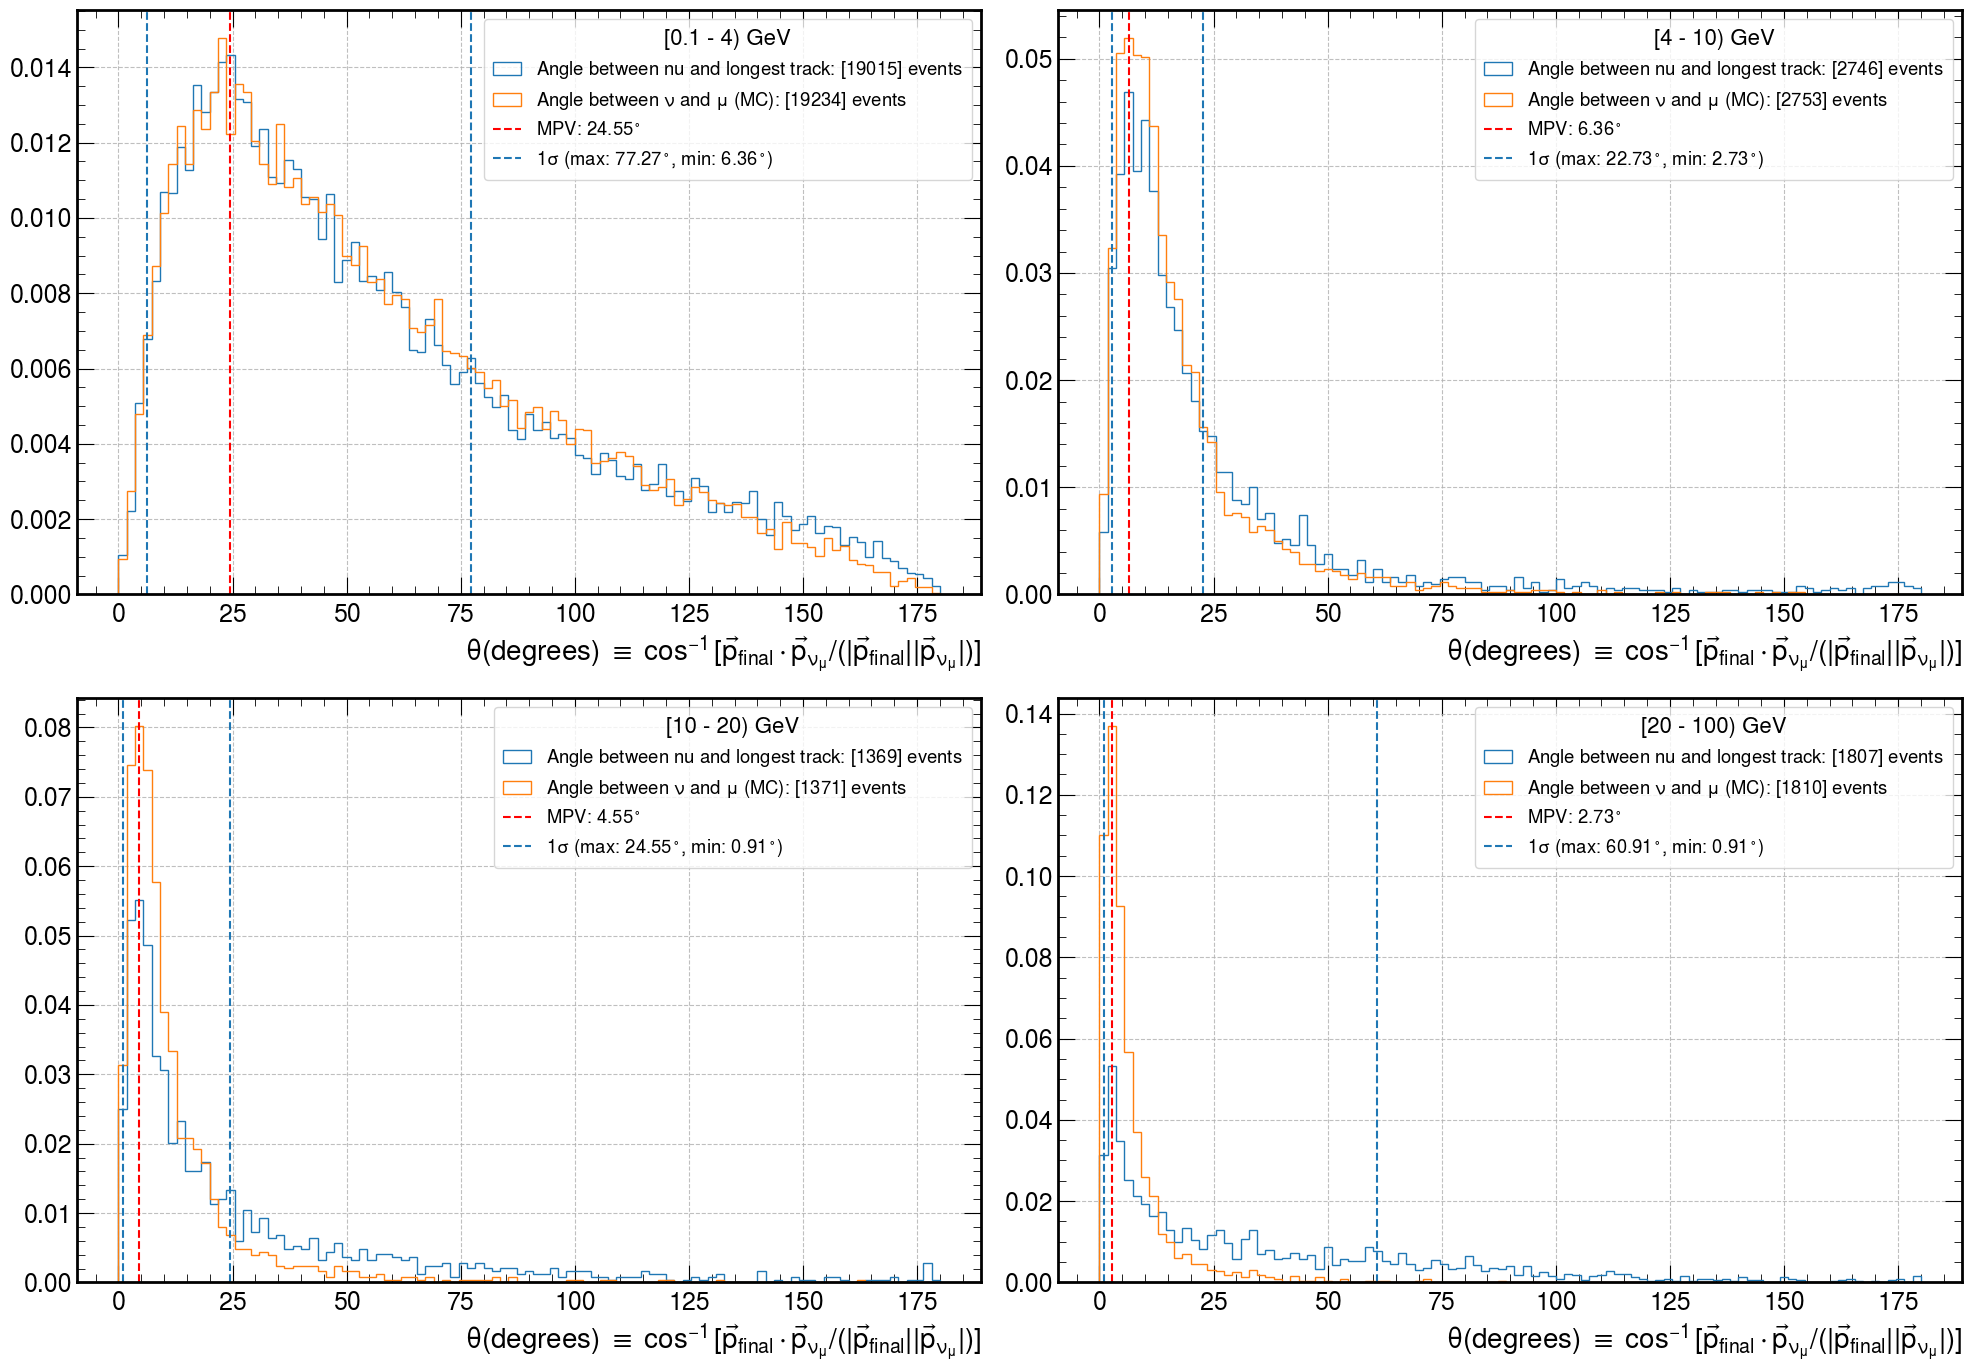

In [9]:
btrack = df.filter(
        (pl.col('ccnc_truth').abs()==0) & (pl.col('nuPDG_truth').abs()==14)
    ).filter(
        True
        # (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
    ).sort('trklen_pandoraTrack',descending=True).groupby(selection_events()).agg(
        pl.col('trklen_pandoraTrack').first().alias('len'),
        nux = pl.col('nu_dcosx_truth').first(),
        nuy = pl.col('nu_dcosy_truth').first(),
        nuz = pl.col('nu_dcosz_truth').first(),
        enu_truth = pl.col('enu_truth').first(),
        tx = pl.col('trkstartdcosx_pandoraTrack').first(),
        ty = pl.col('trkstartdcosy_pandoraTrack').first(),
        tz = pl.col('trkstartdcosz_pandoraTrack').first(),
    ).with_columns(
        diff = (pl.col('nux')*pl.col('tx') + 
        pl.col('nuy')*pl.col('ty') +
        pl.col('nuz')*pl.col('tz')).arccos()*180/np.pi,
    )

q = (
    geant_nu.filter(
        (pl.col('ccnc_truth').abs()==0) & (pl.col('nuPDG_truth').abs()==14)
    ).filter(
        (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
    ).with_columns(
        # angle_diff = get_angle('StartP','nu_dcos',geant_type='drifted_geant'),
        # pl.col('enu_truth'),
        angle_diff = get_angle('P','nu_dcos'),
    ).groupby(selection_events()).agg(
        pl.col('enu_truth').first(),
        angle_diff = get_angle('P','nu_dcos').first(),
    )
)

bins = np.linspace(0,180,100)
Ebins = [0.1,4,10,20,100]
fig, x, y = plot_by_energy(bins=bins,df=btrack,variables=['diff'],labels=[r'Angle between $nu$ and longest track'], columns=2, show_entries=True, figsize=(20,14))
_ , _, _ = plot_by_energy(bins=bins,df=q,variables=['angle_diff'],labels=[r'Angle between $\nu$ and $\mu$ (MC)'], fig=fig, columns=1, show_entries=True, figsize=(20,14))
axes = fig.axes
show_credibility(axes,x,y, idx=0, hist_idx = 0)
show_credibility(axes,x,y, idx=1, hist_idx = 0)
show_credibility(axes,x,y, idx=2, hist_idx = 0)
show_credibility(axes,x,y, idx=3, hist_idx = 0)


In [10]:
btrack = df.filter(
        (pl.col('ccnc_truth').abs()==0) & (pl.col('nuPDG_truth').abs()==14)
    ).filter(
        True
        # (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
    ).sort('trklen_pandoraTrack',descending=True).groupby(selection_events()).agg(

        pl.col('trklen_pandoraTrack').first().alias('len'),
        nux = pl.col('nu_dcosx_truth').first(),
        nuy = pl.col('nu_dcosy_truth').first(),
        nuz = pl.col('nu_dcosz_truth').first(),
        enu_truth = pl.col('enu_truth').first(),
        tx = pl.col('trkstartdcosx_pandoraTrack').first(),
        ty = pl.col('trkstartdcosy_pandoraTrack').first(),
        tz = pl.col('trkstartdcosz_pandoraTrack').first(),
    ).with_columns(
        diff = (pl.col('nux')*pl.col('tx') + 
        pl.col('nuy')*pl.col('ty') +
        pl.col('nuz')*pl.col('tz')).arccos()*180/np.pi,
    )

q = (
    geant_nu.filter(
        (pl.col('ccnc_truth').abs()==0) & (pl.col('nuPDG_truth').abs()==14)
    ).filter(
        (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
    # ).with_columns(
    #     # angle_diff = get_angle('StartP','nu_dcos',geant_type='drifted_geant'),
    #     # pl.col('enu_truth'),
    #     angle_diff = get_angle('P','nu_dcos'),
    # ).groupby(selection_events()).agg(
    #     pl.col('pdg_geant'),
    #     pl.col('enu_truth').first(),
    #     angle_diff = get_angle('P','nu_dcos').first(),
    ).sort(selection_events())
)
q.filter(
    True
    # (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
).groupby(selection_events()).agg(
    pl.all().first()
)
print(len(btrack))
print(len(q))

24937
25171


1637.07055437449

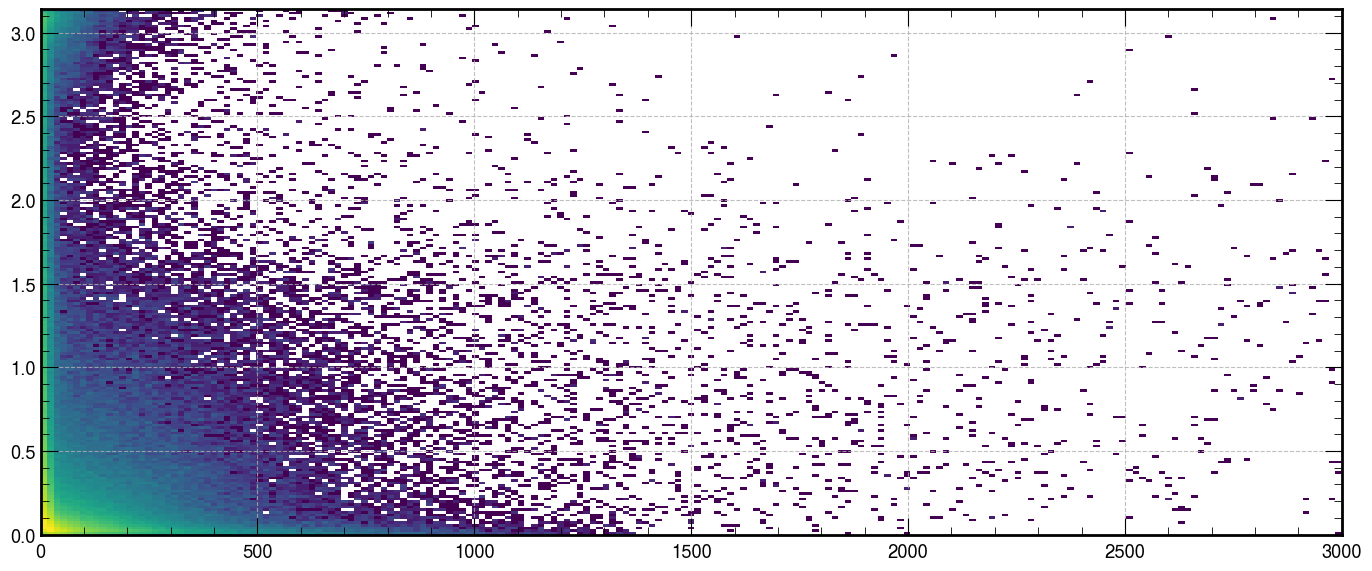

In [11]:
t = df.fill_nan(0)
# t = df.filter(pl.col('pdg_geant').abs()==13)
binsx = np.linspace(0,3000,200)
binsy = np.linspace(0,np.pi,200)
plt.hist2d(t['trklen_pandoraTrack'], t['track_angle_diff'], bins=[binsx,binsy], norm=LogNorm());
np.sqrt(1400**2 + 2*600**2)

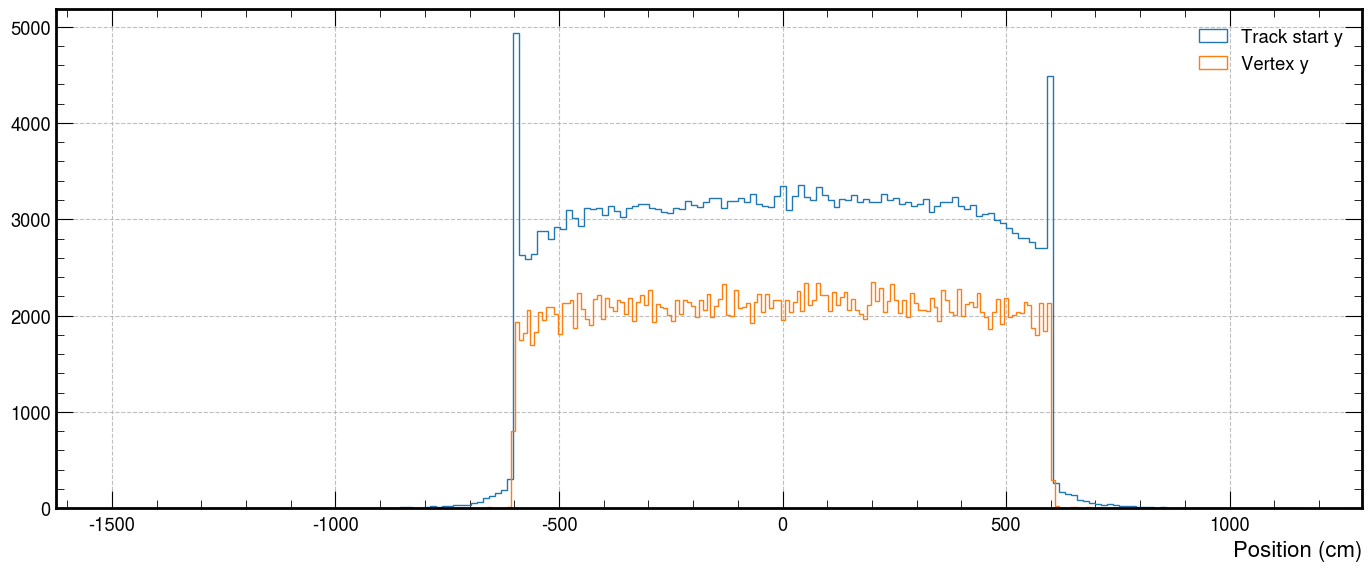

In [15]:

hval, hwidths, _ = plt.hist(df['trkendy_pandoraTrack'], bins=200, label='Track start y', histtype='step')
plt.hist(df['nuvtxy'], bins=200, label='Vertex y', histtype='step')
plt.xlabel('Position (cm)')
# plt.yscale('log')
plt.legend()
# df.filter(
#     pl.col('trklen_pandoraTrack') == pl.max('trklen_pandoraTrack')
# )



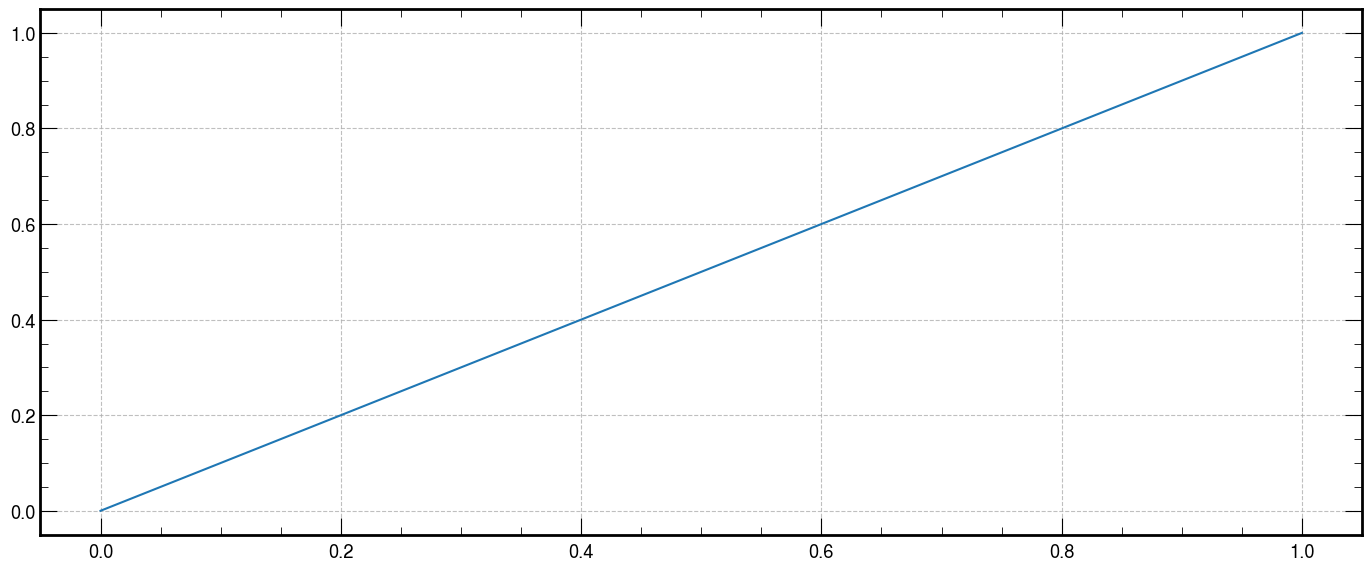

In [13]:
plt.plot([0,1],[0,1], c=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1)
)

In [14]:
merged

subrun,event,trkId_pandoraTrack,trkke_pandoraTrack_x,trkke_pandoraTrack_y,trkke_pandoraTrack_z,trkrange_pandoraTrack_x,trkrange_pandoraTrack_y,trkrange_pandoraTrack_z,trkidtruth_pandoraTrack_x,trkidtruth_pandoraTrack_y,trkidtruth_pandoraTrack_z,trkorigin_pandoraTrack_x,trkorigin_pandoraTrack_y,trkorigin_pandoraTrack_z,trkpdgtruth_pandoraTrack_x,trkpdgtruth_pandoraTrack_y,trkpdgtruth_pandoraTrack_z,trkefftruth_pandoraTrack_x,trkefftruth_pandoraTrack_y,trkefftruth_pandoraTrack_z,trkpurtruth_pandoraTrack_x,trkpurtruth_pandoraTrack_y,trkpurtruth_pandoraTrack_z,trkpitchc_pandoraTrack_x,trkpitchc_pandoraTrack_y,trkpitchc_pandoraTrack_z,ntrkhits_pandoraTrack_x,ntrkhits_pandoraTrack_y,ntrkhits_pandoraTrack_z,trkstartx_pandoraTrack,trkstarty_pandoraTrack,trkstartz_pandoraTrack,trkstartd_pandoraTrack,trkendx_pandoraTrack,trkendy_pandoraTrack,trkendz_pandoraTrack,…,StartPointy_drifted_geant,StartPointz_drifted_geant,StartT_drifted_geant,StartE_drifted_geant,StartP_drifted_geant,StartPx_drifted_geant,StartPy_drifted_geant,StartPz_drifted_geant,EndPointx_drifted_geant,EndPointy_drifted_geant,EndPointz_drifted_geant,EndT_drifted_geant,EndE_drifted_geant,EndP_drifted_geant,EndPx_drifted_geant,EndPy_drifted_geant,EndPz_drifted_geant,NumberDaughters_geant,Mother_geant,MergedId_geant,origin_geant,MCTruthIndex_geant,process_primary_geant,processname_geant,nuPDG_truth,ccnc_truth,nuvtxx_truth,nuvtxy_truth,nuvtxz_truth,enu_truth,nu_dcosx_truth,nu_dcosy_truth,nu_dcosz_truth,mode_truth,nuvtxx,nuvtxy,nuvtxz
i32,i32,i16,f32,f32,f32,f32,f32,f32,i32,i32,i32,i16,i16,i16,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,i32,str,i32,i32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32
0,1,0,432.699432,448.642883,298.362366,184.384445,183.453522,178.304245,2,2,2,1,1,1,13,13,13,0.965925,0.954526,0.55304,0.990644,0.954377,1.0,0.659388,1.249107,2.315049,241,175,45,-131.309006,-280.038116,663.453064,232.067047,-210.664413,-116.096329,683.59668,…,-280.151184,663.148743,0.0,0.535018,0.524481,-0.244455,0.457174,0.079463,-209.704437,-117.042099,683.811462,0.0,0.105658,0.0,0.0,0.0,0.0,13,0,0,1,0,1,"""primary""",14,0,-130.061508,-280.151184,663.148743,0.655947,-0.977776,0.202831,-0.053163,0,-131.552872,-279.836426,662.629028
0,1,1,99.552086,69.731926,85.474777,8.926783,5.114771,7.947288,3,3,3,1,1,1,2212,2212,2212,0.98654,0.836766,0.822465,0.966021,1.0,0.831841,0.935816,1.431398,4.505156,10,5,5,-131.341614,-279.849548,663.143066,232.034439,-137.807816,-286.378937,662.160461,…,-280.151184,663.148743,0.0,1.048149,0.467185,-0.357646,-0.296653,-0.048461,-137.119781,-286.309143,662.021545,0.0,0.938272,0.0,-0.0,-0.0,-0.0,0,0,0,1,0,1,"""primary""",14,0,-130.061508,-280.151184,663.148743,0.655947,-0.977776,0.202831,-0.053163,0,-131.552872,-279.836426,662.629028
1000,1,0,118.071609,84.082695,97.858482,34.146835,31.70542,31.632025,2,2,2,1,1,1,13,13,13,0.735311,0.802747,0.590764,0.655607,0.911396,0.931699,7.499642,2.155011,4.97654,30,30,20,-156.143326,-157.985184,162.480255,163.356506,-122.844223,-154.129852,156.804062,…,-158.735779,162.615845,0.0,0.219211,0.192067,0.182073,0.022561,-0.056836,-120.533432,-153.137848,157.142181,0.0,0.105658,0.0,0.0,0.0,-0.0,8,0,0,1,0,1,"""primary""",14,0,-155.296707,-158.735779,162.615845,0.355979,0.68132,0.375561,0.628305,0,-156.034576,-158.446335,162.541809
1000,1,1,30.376743,26.641705,78.272865,5.680715,4.838762,4.761273,468,468,468,1,1,1,11,11,11,0.672334,0.54935,0.919833,0.729589,0.913359,0.830461,0.487602,7.171271,0.760976,12,6,8,-121.904617,-153.011978,157.8004,158.676651,-121.104263,-157.352921,154.224625,…,-153.137848,157.142181,259.800171,0.025028,0.025023,-0.009458,-0.022219,-0.006557,-120.151016,-156.942703,153.79982,259.800171,0.000511,0.0,-0.0,0.0,-0.0,0,2,0,1,0,0,"""muMinusCapture…",14,0,-155.296707,-158.735779,162.615845,0.355979,0.68132,0.375561,0.628305,0,-156.034576,-158.446335,162.541809
1000,2,0,175.863174